<a href="https://colab.research.google.com/github/sohaibsyed21/572CookCounty/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Initital set up

# Mount to google drive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')

# If you encounter any problems visit the apache.org link and ensure you have selected the right tgz file
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www.apache.org/dist/spark/spark-3.2.4/spark-3.2.4-bin-hadoop2.7.tgz
!tar xf spark-3.2.4-bin-hadoop2.7.tgz

# Setting the appropriate paths for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop2.7"

!pip install -q findspark
import findspark
findspark.init()

import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_timestamp, log
from pyspark.sql import Window
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DateType, FloatType
import pandas as pd
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
#!pip install pyspark_dist_explore
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

# Change directory
import os
os.chdir("/content/gdrive/MyDrive/CSP 572/")

# Create a spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Mounted at /content/gdrive


In [ ]:
# Read 2022 data
data_2022 = spark.read.csv("2022.rpt", header=None, sep="|")

header = pd.read_csv("Header.rpt", sep="|")
cols = header.columns
data_2022 = data_2022.toDF(*cols)

# Read 2021 data
data_2021 = spark.read.csv("2021.rpt", header=None, sep="|")
data_2021 = data_2021.toDF(*cols)

# Read all years data
data_2020 = spark.read.csv("2020.rpt", header=None, sep="|")
data_2020 = data_2020.toDF(*cols)
data_2019 = spark.read.csv("2019.rpt", header=None, sep="|")
data_2019 = data_2019.toDF(*cols)
data_2018 = spark.read.csv("2018.rpt", header=None, sep="|")
data_2018 = data_2018.toDF(*cols)
data_2017 = spark.read.csv("2017.rpt", header=None, sep="|")
data_2017 = data_2017.toDF(*cols)

# Create TC column which contains only first two digits of Tax Code
data_2022 = data_2022.withColumn("P2", col("PIN")[0:2])
data_2021 = data_2021.withColumn("P2", col("PIN")[0:2])
data_2020 = data_2020.withColumn("P2", col("PIN")[0:2])
data_2019 = data_2019.withColumn("P2", col("PIN")[0:2])
data_2018 = data_2018.withColumn("P2", col("PIN")[0:2])
data_2017 = data_2017.withColumn("P2", col("PIN")[0:2])

# Numeric columns list - add to this as you see fit
numeric_cols = ["AdjustedAmountDue1", "TaxAmountDue1", "InterestAmountDue1", "CostAmountDue1", "TotalAmountDue1", "OriginalTaxDue2",
        "AdjustedTaxDue2", "TaxAmountDue2", "InterestAmountDue2", "CostAmountDue2", "TotalAmountDue2", "AssessedValuation",
        "EqualizedEvaluation", "TaxRate", "LastPaymentReceivedAmount1", "LastPaymentReceivedAmount2"
        ] + list(data_2021.columns)[70:81]

for col_name in numeric_cols:
    data_2022 = data_2022.withColumn(col_name, col(col_name).cast('float'))
    data_2021 = data_2021.withColumn(col_name, col(col_name).cast('float'))
    data_2020 = data_2020.withColumn(col_name, col(col_name).cast('float'))
    data_2019 = data_2019.withColumn(col_name, col(col_name).cast('float'))
    data_2018 = data_2018.withColumn(col_name, col(col_name).cast('float'))
    data_2017 = data_2017.withColumn(col_name, col(col_name).cast('float'))

# Remove 3 rows which have garbage values
# data_2022 = data_2022.where(data_2022.SegmentCode=="PH")
# data_2021 = data_2021.where(data_2021.SegmentCode=="PH")
# data_2020 = data_2020.where(data_2020.SegmentCode=="PH")
# data_2019 = data_2019.where(data_2019.SegmentCode=="PH")
# data_2018 = data_2018.where(data_2018.SegmentCode=="PH")
# data_2017 = data_2017.where(data_2017.SegmentCode=="PH")

# Read Installment dates data
instDates = spark.read.csv("InstDates.csv", header=True)
instDates = instDates.withColumn("Year", col("Year").cast("int"))
instDates = instDates.where(instDates.Year>=2017)
instDates = instDates.withColumnRenamed("Inst1", "PmtDue1")
instDates = instDates.withColumnRenamed("Inst2", "PmtDue2")

# Read Payment source Def data
pmtSourceDef = spark.read.csv("PaymentSourceDef.csv", header=True)
pmtSourceDef = pmtSourceDef.withColumnRenamed("Source ID", "srcID")
pmtSourceDef = pmtSourceDef.withColumnRenamed("Payment Description", "PmtDesc")
pmtSourceDef = pmtSourceDef.withColumnRenamed("Payment Source", "PmtSrc")
pmtSourceDef = pmtSourceDef.withColumnRenamed("Payment Method", "PmtMethod")

In [ ]:
# Joining Payment Source Def
data_2022 = data_2022.join(pmtSourceDef, data_2022.LastPaymentSource1 == pmtSourceDef.srcID, "left")
data_2021 = data_2021.join(pmtSourceDef, data_2021.LastPaymentSource1 == pmtSourceDef.srcID, "left")
data_2020 = data_2020.join(pmtSourceDef, data_2020.LastPaymentSource1 == pmtSourceDef.srcID, "left")
data_2019 = data_2019.join(pmtSourceDef, data_2019.LastPaymentSource1 == pmtSourceDef.srcID, "left")
data_2018 = data_2018.join(pmtSourceDef, data_2018.LastPaymentSource1 == pmtSourceDef.srcID, "left")
data_2017 = data_2017.join(pmtSourceDef, data_2017.LastPaymentSource1 == pmtSourceDef.srcID, "left")


In [ ]:
# Drop rows where Tax Status is 100% exempt (01)
data_2022 = data_2022.where(data_2022.TaxStatus != 1)
data_2021 = data_2021.where(data_2021.TaxStatus != 1)
data_2020 = data_2020.where(data_2020.TaxStatus != 1)
data_2019 = data_2019.where(data_2019.TaxStatus != 1)
data_2018 = data_2018.where(data_2018.TaxStatus != 1)
data_2017 = data_2017.where(data_2017.TaxStatus != 1)

In [ ]:
# Drop rows where Payment Source is TPA
data_2022 = data_2022.where(data_2022.PmtSrc != 'TPA')
data_2021 = data_2021.where(data_2021.PmtSrc != 'TPA')
data_2020 = data_2020.where(data_2020.PmtSrc != 'TPA')
data_2019 = data_2019.where(data_2019.PmtSrc != 'TPA')
data_2018 = data_2018.where(data_2018.PmtSrc != 'TPA')
data_2017 = data_2017.where(data_2017.PmtSrc != 'TPA')

In [ ]:
# 2022 data - creating new columns
data_2022 = data_2022.join(instDates, data_2022.TaxYear == instDates.Year, "left")
data_2022 = data_2022.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2022 = data_2022.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2022 = data_2022.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2022 = data_2022.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2022 = data_2022.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2022 = data_2022.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2021 data - creating new columns
data_2021 = data_2021.join(instDates, data_2021.TaxYear == instDates.Year, "left")
data_2021 = data_2021.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2021 = data_2021.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2021 = data_2021.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2021 = data_2021.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2021 = data_2021.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2021 = data_2021.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2020 data - creating new columns
data_2020 = data_2020.join(instDates, data_2020.TaxYear == instDates.Year, "left")
data_2020 = data_2020.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2020 = data_2020.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2020 = data_2020.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2020 = data_2020.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2020 = data_2020.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2020 = data_2020.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2019 data - creating new columns
data_2019 = data_2019.join(instDates, data_2019.TaxYear == instDates.Year, "left")
data_2019 = data_2019.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2019 = data_2019.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2019 = data_2019.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2019 = data_2019.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2019 = data_2019.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2019 = data_2019.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2018 data - creating new columns
data_2018 = data_2018.join(instDates, data_2018.TaxYear == instDates.Year, "left")
data_2018 = data_2018.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2018 = data_2018.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2018 = data_2018.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2018 = data_2018.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2018 = data_2018.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2018 = data_2018.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2017 data - creating new columns
data_2017 = data_2017.join(instDates, data_2017.TaxYear == instDates.Year, "left")
data_2017 = data_2017.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2017 = data_2017.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2017 = data_2017.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2017 = data_2017.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2017 = data_2017.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2017 = data_2017.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

In [ ]:
#data transformation 2022 data
data_2022 = data_2022.withColumn("TaxpayerPropertyCity", when(data_2022.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
data_2022 = data_2022.withColumn("TaxpayerMailingState", when(data_2022.TaxpayerMailingState=="IL", 1).otherwise(0))
data_2022 = data_2022.withColumn("BillType", when(data_2022.BillType=="1", 1).otherwise(0))
data_2022 = data_2022.withColumn("TaxSale", when(data_2022.LastPaymentDate2=="00000000", 1).otherwise(0))
data_2022 = data_2022.withColumn("CofENumber", when(data_2022.CofENumber=="0000000", 0).otherwise(1))
data_2022 = data_2022.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data_2022 = data_2022.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
data_2022 = data_2022.withColumn("Volume", col("Volume").cast("int"))
data_2022 = data_2022.withColumn("TaxStatus", col("TaxStatus").cast("int"))
data_2022 = data_2022.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

# Data transformation for all other years
data_list = [data_2021, data_2020, data_2019, data_2018, data_2017]
for data in data_list:
  data = data.withColumn("TaxpayerPropertyCity", when(data.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
  data = data.withColumn("TaxpayerMailingState", when(data.TaxpayerMailingState=="IL", 1).otherwise(0))
  data = data.withColumn("BillType", when(data.BillType=="1", 1).otherwise(0))
  data = data.withColumn("TaxSale", when(data.LastPaymentDate2=="00000000", 1).otherwise(0))
  data = data.withColumn("CofENumber", when(data.CofENumber=="0000000", 0).otherwise(1))
  data = data.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
  data = data.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
  data = data.withColumn("Volume", col("Volume").cast("int"))
  data = data.withColumn("TaxStatus", col("TaxStatus").cast("int"))
  data = data.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

data_2021 = data_list[0]
data_2020 = data_list[1]
data_2019 = data_list[2]
data_2018 = data_list[3]
data_2017 = data_list[4]

In [ ]:
allData.show(n=10)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
allData = data_2021.union(data_2020)
allData = allData.union(data_2019)
allData = allData.union(data_2018)
allData = allData.union(data_2017)

In [ ]:
#all data transformation
allData = allData.withColumn("TaxpayerPropertyCity", when(allData.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
allData = allData.withColumn("TaxpayerMailingState", when(allData.TaxpayerMailingState=="IL", 1).otherwise(0))
allData = allData.withColumn("BillType", when(allData.BillType=="1", 1).otherwise(0))
allData = allData.withColumn("TaxSale", when(allData.LastPaymentDate2=="00000000", 1).otherwise(0))
allData = allData.withColumn("CofENumber", when(allData.CofENumber=="0000000", 0).otherwise(1))
allData = allData.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
allData = allData.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
allData = allData.withColumn("Volume", col("Volume").cast("int"))
allData = allData.withColumn("TaxStatus", col("TaxStatus").cast("int"))
allData = allData.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

In [ ]:
allData = allData.persist()

In [ ]:
allData.count()

9325502

In [ ]:
allData = allData.withColumn("DiffPmt2", f.datediff(col("LastPaymentDate2"), col("PmtDue2")))
allData = allData.withColumn("DiffPmt2", when(col("DiffPmt2")<0,0).otherwise(col("DiffPmt2")))

In [ ]:
pmtSourceDef = pmtSourceDef.withColumnRenamed("PmtSrc", "PmtSrc2")
allData = allData.withColumn("pmtSourceDef2", allData.LastPaymentSource2 == pmtSourceDef.srcID, "left")

AnalysisException: ignored

In [ ]:
allData.schema["PIN"].dataType

StringType

In [ ]:
allData.columns

['SegmentCode',
 'PIN',
 'Volume',
 'Classification',
 'TaxpayerName',
 'TaxpayerMailingAddress',
 'TaxpayerMailingCity',
 'TaxpayerMailingState',
 'TaxpayerMailingZip',
 'TaxpayerPropertyHouse',
 'TaxpayerPropertyDirection',
 'TaxpayerPropertyStreet',
 'TaxpayerPropertySuffix',
 'TaxpayerPropertyCity',
 'TaxpayerPropertyState',
 'TaxpayerPropertyZip',
 'TaxpayerPropertyTown',
 'TaxCode',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'LongtimeHomeownersExempt',
 'TaxInfoType',
 'TaxType',
 'TaxYear',
 'BillYear',
 'AccountStatus',
 'BillType',
 'SegmentCode2',
 'InstallmentNumber1',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'RefundTaxAmountDueIndicator1',
 'InterestAmountDue1',
 'RefundInterestDueIndicator1',
 'CostAmountDue1',
 'RefundCostDueIndicator1',
 'TotalAmountDue1',
 'RefundTotalDueIndicator1',
 'LastPaymentDate1',
 'LastPaymentSource1',
 'InstallmentNumber2',
 'OriginalTaxDue2',
 'AdjustedTaxDue2',
 'TaxAmountDue2',
 'RefundTaxAmountDueIndicator2'

In [ ]:
allData.count()

9325502

In [ ]:
allData = allData.where(allData.SegmentCode=="PH")
allData.count()

9325500

In [ ]:
allData = allData.where(allData.TaxStatus != 1)
allData.count()

8866794

In [ ]:
allData = allData.persist()

In [ ]:
allData.count()

8866794

In [ ]:
allData.dtypes

[('SegmentCode', 'string'),
 ('PIN', 'string'),
 ('Volume', 'int'),
 ('Classification', 'string'),
 ('TaxpayerName', 'string'),
 ('TaxpayerMailingAddress', 'string'),
 ('TaxpayerMailingCity', 'string'),
 ('TaxpayerMailingState', 'int'),
 ('TaxpayerMailingZip', 'string'),
 ('TaxpayerPropertyHouse', 'string'),
 ('TaxpayerPropertyDirection', 'string'),
 ('TaxpayerPropertyStreet', 'string'),
 ('TaxpayerPropertySuffix', 'string'),
 ('TaxpayerPropertyCity', 'int'),
 ('TaxpayerPropertyState', 'string'),
 ('TaxpayerPropertyZip', 'string'),
 ('TaxpayerPropertyTown', 'string'),
 ('TaxCode', 'string'),
 ('TaxStatus', 'int'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('LongtimeHomeownersExempt', 'string'),
 ('TaxInfoType', 'string'),
 ('TaxType', 'string'),
 ('TaxYear', 'string'),
 ('BillYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'int'),
 ('SegmentCode2', 'string'),
 ('InstallmentNumber1', 'string'),
 ('AdjustedAmountDue1', 

In [ ]:
allData = allData.where((allData.AdjustedAmountDue1 != 0) & (allData.AdjustedTaxDue2 != 0))
allData.count()

8409575

In [ ]:
allData = allData.where(allData.PmtSrc != 'TPA')
allData.count()

4381271

In [ ]:
allData = allData.where(allData.LastPaymentSource2 != '527')
allData = allData.where(allData.LastPaymentSource2 != '600')
allData = allData.where(allData.LastPaymentSource2 != '800')
allData = allData.where(allData.LastPaymentSource2 != '802')
allData = allData.where(allData.LastPaymentSource2 != '830')
allData.count()

4208885

In [ ]:
allData = allData.where(allData.DiffPmt2 < 500)
allData.count()

4168936

In [ ]:
allData = allData.where(allData.DiffPmt1 < 680)
allData.count()

4168935

In [ ]:
print("Unique 2-digit PIN 2017-2021 ", allData.select("P2").distinct().count())

Unique 2-digit PIN 2017-2021  33


In [ ]:
print("Unique PIN 2017-2021 ", allData.select("PIN").distinct().count())

Unique PIN 2017-2021  1094482


In [ ]:
allData.groupBy("PIN").agg(count("PIN")).show(100)

+--------------+----------+
|           PIN|count(PIN)|
+--------------+----------+
|08321010301032|         5|
|08321010301045|         1|
|09144090410000|         5|
|09174050160000|         5|
|09174040270000|         5|
|09174080341006|         5|
|09174190411139|         5|
|07151090090000|         2|
|09194110100000|         5|
|09204050220000|         5|
|09204090230000|         5|
|09211000140000|         5|
|09211000261048|         5|
|09211000271022|         5|
|09223010140000|         1|
|09223010320000|         5|
|09222000300000|         5|
|09224170250000|         5|
|09223200100000|         3|
|09231010090000|         5|
|09231010310000|         5|
|09231020700000|         5|
|09231030840000|         5|
|09231030950000|         5|
|09231170620000|         5|
|09233130110000|         5|
|09233170130000|         3|
|09241000230000|         5|
|09234060580000|         5|
|09242090230000|         4|
|09241120680000|         5|
|09243300040000|         5|
|09244010620000|    

In [ ]:
allData.groupBy("P2").agg(count("P2")).show(33)

+---+---------+
| P2|count(P2)|
+---+---------+
| 07|   116632|
| 11|    69582|
| 01|    24850|
| 09|   163413|
| 08|    93450|
| 03|   172534|
| 02|   116639|
| 10|   187118|
| 12|   152942|
| 13|   325593|
| 05|    83255|
| 06|    69296|
| 04|   120469|
| 14|   300387|
| 15|   151622|
| 22|    27692|
| 16|   265605|
| 18|   121292|
| 17|   509917|
| 19|   202402|
| 23|    66613|
| 24|   172772|
| 20|   214191|
| 21|    17000|
| 29|    93951|
| 28|    97082|
| 27|   107355|
| 26|    41805|
| 25|   153252|
| 30|    37433|
| 31|    49731|
| 33|    11053|
| 32|    63313|
+---+---------+



In [ ]:
# Read 2021 data
data_2021 = spark.read.csv("2021.rpt", header=None, sep="|")
data_2021 = data_2021.toDF(*cols)

In [ ]:
# Read all years data
data_2020 = spark.read.csv("2020.rpt", header=None, sep="|")
data_2020 = data_2020.toDF(*cols)
data_2019 = spark.read.csv("2019.rpt", header=None, sep="|")
data_2019 = data_2019.toDF(*cols)
data_2018 = spark.read.csv("2018.rpt", header=None, sep="|")
data_2018 = data_2018.toDF(*cols)
data_2017 = spark.read.csv("2017.rpt", header=None, sep="|")
data_2017 = data_2017.toDF(*cols)

In [ ]:
print("2022: ", data_2022.select("PIN").distinct().count())
print("2021: ", data_2021.select("PIN").distinct().count())
print("2020: ", data_2020.select("PIN").distinct().count())
print("2019: ", data_2019.select("PIN").distinct().count())
print("2018: ", data_2018.select("PIN").distinct().count())
print("2017: ", data_2017.select("PIN").distinct().count())

2022:  47136
2021:  874986
2020:  895014
2019:  889452
2018:  897794
2017:  932241


In [ ]:
print("2022: ", data_2022.select("P2").distinct().count())
print("2021: ", data_2021.select("P2").distinct().count())
print("2020: ", data_2020.select("P2").distinct().count())
print("2019: ", data_2019.select("P2").distinct().count())
print("2018: ", data_2018.select("P2").distinct().count())
print("2017: ", data_2017.select("P2").distinct().count())

2022:  8
2021:  33
2020:  33
2019:  33
2018:  33
2017:  33


In [ ]:
print(data_2022.count())
print(data_2021.count())
print(data_2020.count())
print(data_2019.count())
print(data_2018.count())
print(data_2017.count())

116307
1863592
1864779
1865486
1865353
1865486


In [ ]:
data_2022.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|            4120|
|       00|          112185|
|       03|               2|
+---------+----------------+



In [ ]:
data_2021.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|           92042|
|       00|         1431302|
|       05|             333|
|       03|          339840|
|       04|              75|
+---------+----------------+



In [ ]:
data_2020.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|           90971|
|       00|         1453953|
|       05|             310|
|       03|          319470|
|       04|              75|
+---------+----------------+



In [ ]:
data_2019.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|           91510|
|       00|         1448430|
|       05|             465|
|       03|          325006|
|       04|              75|
+---------+----------------+



In [ ]:
data_2018.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|           92267|
|       00|         1481025|
|       05|             511|
|       03|          291476|
|       04|              74|
+---------+----------------+



In [ ]:
data_2017.groupBy("TaxStatus").agg(count("TaxStatus")).show()

+---------+----------------+
|TaxStatus|count(TaxStatus)|
+---------+----------------+
|       01|           91510|
|       00|         1448430|
|       05|             465|
|       03|          325006|
|       04|              75|
+---------+----------------+



In [ ]:
allData = data_2021.union(data_2020)
allData = allData.union(data_2019)
allData = allData.union(data_2018)
allData = allData.union(data_2017)

In [ ]:
# Drop rows where Tax Status is 100% exempt (01)

data_2022 = data_2022.where(data_2022.TaxStatus != 1)
data_2021 = data_2021.where(data_2021.TaxStatus != 1)
data_2020 = data_2020.where(data_2020.TaxStatus != 1)
data_2019 = data_2019.where(data_2019.TaxStatus != 1)
data_2018 = data_2018.where(data_2018.TaxStatus != 1)
data_2017 = data_2017.where(data_2017.TaxStatus != 1)

In [ ]:
print(data_2022.count())
print(data_2021.count())
print(data_2020.count())
print(data_2019.count())
print(data_2018.count())
print(data_2017.count())

112187
1771550
1773808
1773976
1773086
1773976


In [ ]:
# Drop rows where Payment Source is TPA
data_2022 = data_2022.where(data_2022.PmtSrc != 'TPA')
data_2021 = data_2021.where(data_2021.PmtSrc != 'TPA')
data_2020 = data_2020.where(data_2020.PmtSrc != 'TPA')
data_2019 = data_2019.where(data_2019.PmtSrc != 'TPA')
data_2018 = data_2018.where(data_2018.PmtSrc != 'TPA')
data_2017 = data_2017.where(data_2017.PmtSrc != 'TPA')

In [ ]:
print(data_2021.count())
print(data_2020.count())
print(data_2019.count())
print(data_2018.count())
print(data_2017.count())

874988
895014
889456
897808
889456


In [ ]:
PmtSrc_Counts_17 = data_2017.groupBy("PmtSrc").agg(count("PmtSrc"))

In [ ]:
PmtSrc_Counts_17.show()

+-----------+-------------+
|     PmtSrc|count(PmtSrc)|
+-----------+-------------+
|  In-person|       303878|
|        ACH|       343512|
|Credit Card|        37456|
|       null|            0|
|       Mail|       189043|
| Correction|          619|
|        TPA|       774975|
|   Tax Sale|        14948|
+-----------+-------------+



In [ ]:
allData = data_2021.union(data_2020)
allData = allData.union(data_2019)
allData = allData.union(data_2018)
allData = allData.union(data_2017)


In [ ]:
print(allData.count())

4489518


In [ ]:
allData.show(30)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
TC_groups = allData.groupBy("TC")

In [ ]:
allData.groupBy("TC").sum("LatePmt2").show(38)

+---+-------------+
| TC|sum(LatePmt2)|
+---+-------------+
| 29|        14576|
| 22|        18849|
| 35|        14462|
| 16|        11197|
| 71|        56389|
| 75|        10045|
| 17|         9051|
| 26|         3541|
| 77|        76907|
| 38|        20200|
| 24|        17013|
| 20|        13243|
| 10|         3149|
| 73|        38154|
| 18|         9868|
| 23|         9903|
| 25|        14010|
| 74|        35747|
| 15|         8765|
| 11|         5832|
| 30|         8708|
| 34|         2048|
| 31|        21809|
| 70|        73189|
| 27|         6560|
| 19|         3303|
| 33|         1841|
| 36|         5444|
| 39|        23086|
| 21|        17028|
| 72|       108666|
| 28|        11845|
| 37|        42731|
| 13|        21455|
| 14|         3925|
| 32|        12987|
| 12|        20705|
| 76|        29173|
+---+-------------+



In [ ]:
allData.groupBy("TC").sum("LatePmt2").show()

+---+-------------+
| TC|sum(LatePmt2)|
+---+-------------+
| 29|        14576|
| 22|        18849|
| 35|        14462|
| 16|        11197|
| 71|        56389|
| 75|        10045|
| 17|         9051|
| 26|         3541|
| 77|        76907|
| 38|        20200|
| 24|        17013|
| 20|        13243|
| 10|         3149|
| 73|        38154|
| 18|         9868|
| 23|         9903|
| 25|        14010|
| 74|        35747|
| 15|         8765|
| 11|         5832|
+---+-------------+
only showing top 20 rows



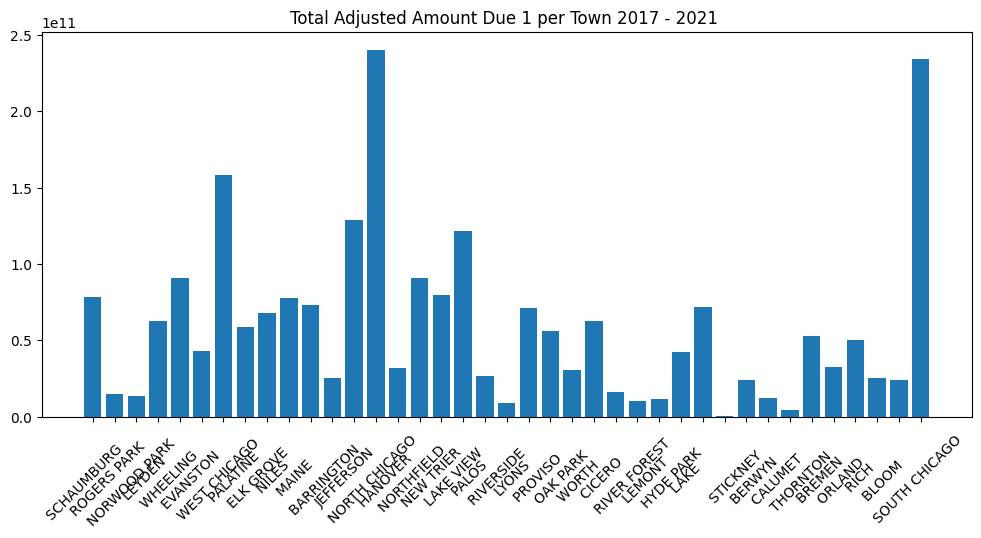

In [ ]:
TC_Counts = allData.groupBy("TaxpayerPropertyTown").sum("AdjustedAmountDue1")
counts = TC_Counts.rdd.map(lambda x: x[1]).collect()
mylabels = TC_Counts.rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.xticks(mylabels, mylabels, rotation=45)
plt.title("Total Adjusted Amount Due 1 per Town 2017 - 2021 ")
plt.show()

In [ ]:
print(mylabels)
print(counts)

['SCHAUMBURG     ', 'ROGERS PARK    ', 'NORWOOD PARK   ', 'LEYDEN         ', 'WHEELING       ', 'EVANSTON       ', 'WEST CHICAGO   ', 'PALATINE       ', 'ELK GROVE      ', 'NILES          ', 'MAINE          ', 'BARRINGTON     ', 'JEFFERSON      ', 'NORTH CHICAGO  ', 'HANOVER        ', 'NORTHFIELD     ', 'NEW TRIER      ', 'LAKE VIEW      ', 'PALOS          ', 'RIVERSIDE      ', 'LYONS          ', 'PROVISO        ', 'OAK PARK       ', 'WORTH          ', 'CICERO         ', 'RIVER FOREST   ', 'LEMONT         ', 'HYDE PARK      ', 'LAKE           ', '               ', 'STICKNEY       ', 'BERWYN         ', 'CALUMET        ', 'THORNTON       ', 'BREMEN         ', 'ORLAND         ', 'RICH           ', 'BLOOM          ', 'SOUTH CHICAGO  ']
[78029422475.0, 14580731889.0, 13392347209.0, 62908875003.0, 90955826603.0, 43082289191.0, 158513074807.0, 58374050785.0, 67888284959.0, 77460950817.0, 73172580917.0, 25337967428.0, 129028046601.0, 240041446829.0, 31550092595.0, 90838029001.0, 79778507978.0,

In [ ]:
print(mylabels[-10])
print(counts[-10])

               
135994908.0


In [ ]:
labels2 = mylabels
c2 = counts
mylab2 = mylabels.pop(-10)
c3 = counts.pop(-10)

print(mylab2)
print(c3)

               
135994908.0


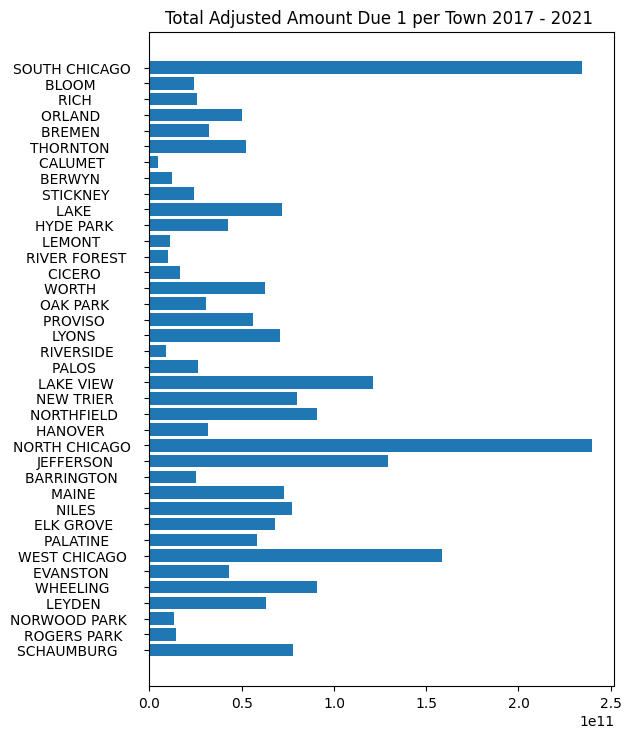

In [ ]:
plt.figure(figsize=(6,8.5))
plt.barh(mylabels, counts)
#plt.yticks(mylabels, mylabels)
plt.title("Total Adjusted Amount Due 1 per Town 2017 - 2021 ")
plt.show()

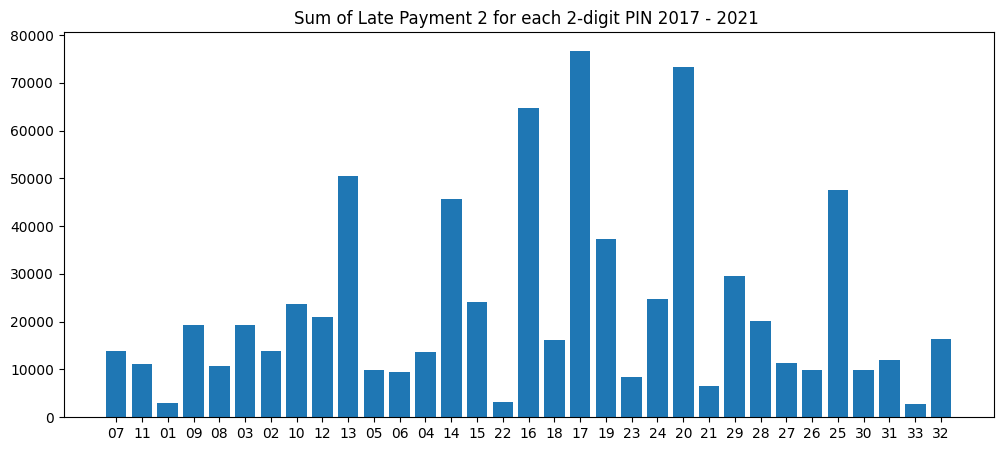

In [ ]:
TC_Counts = allData.groupBy("P2").sum("LatePmt2")
counts = TC_Counts.rdd.map(lambda x: x[1]).collect()
mylabels = TC_Counts.rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.title("Sum of Late Payment 2 for each 2-digit PIN 2017 - 2021 ")
plt.show()

In [ ]:
TC_Counts = allData.groupBy("P2").sum("LatePmt2")
late_counts = TC_Counts.rdd.map(lambda x: x[1]).collect()

In [ ]:
from pyspark.sql.functions import sum
allData.select(sum(allData.LatePmt2)).show()

+-------------+
|sum(LatePmt2)|
+-------------+
|       805404|
+-------------+



In [ ]:
print(type(counts))
print(len(counts))

list

In [ ]:
percent_late = []
for i in range(len(counts)):
  p = (late_counts[i]) / counts[i] * 100
  percent_late.append(p)

In [ ]:
print(counts)

[117287, 70295, 24995, 164391, 94021, 173465, 117324, 188638, 154528, 329742, 83605, 69803, 120998, 303182, 154392, 27866, 275379, 122473, 515421, 206348, 67196, 175289, 229856, 18576, 100565, 100230, 108000, 43376, 163375, 39194, 51783, 11442, 66483]


In [ ]:
print(late_counts)

[14462, 11561, 3149, 20260, 11201, 20200, 14576, 24793, 21959, 52968, 10446, 9868, 14339, 47683, 25698, 3303, 69046, 16890, 80127, 39215, 8846, 26263, 79335, 7246, 32077, 21455, 11845, 10425, 51822, 10654, 12987, 3006, 17699]


In [ ]:
print(len(counts))
print(len(late_counts))

33
33


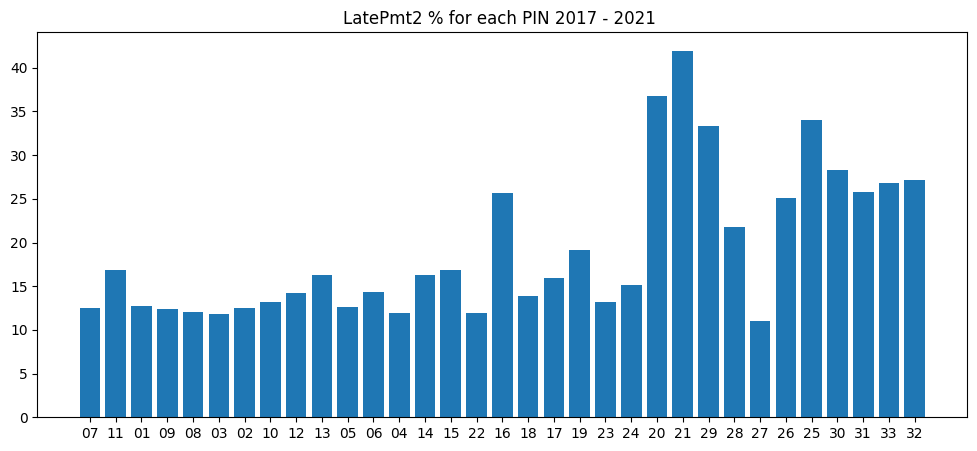

In [ ]:
plt.figure(figsize=(12,5))
plt.bar( mylabels, percent_late)
plt.title("LatePmt2 % for each PIN 2017 - 2021 ")
plt.show()

In [ ]:
TC_Counts = allData.groupBy("P2").agg(count("P2"))
counts = TC_Counts.rdd.map(lambda x: x[1]).collect()
mylabels = TC_Counts.rdd.map(lambda x: x[0]).collect()



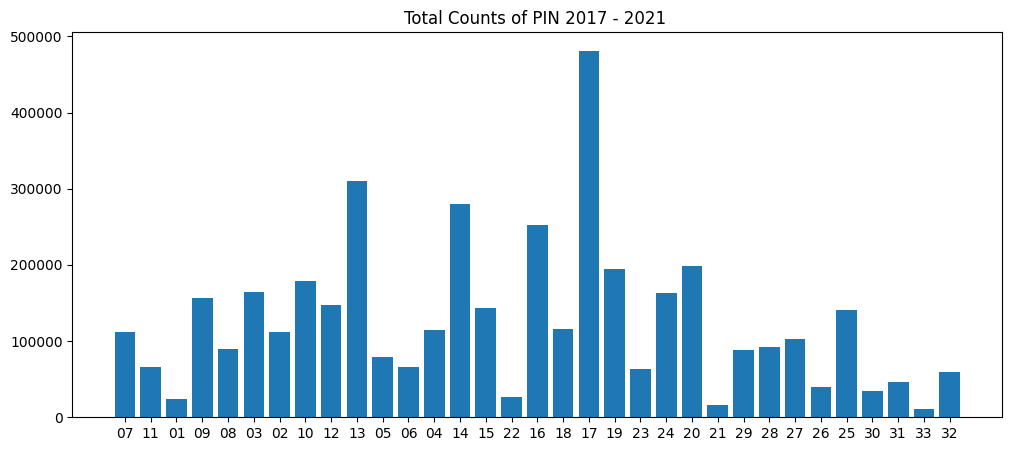

In [ ]:
plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.title("Total Counts of PIN 2017 - 2021 ")
plt.show()

In [ ]:
allData.count()

4489518

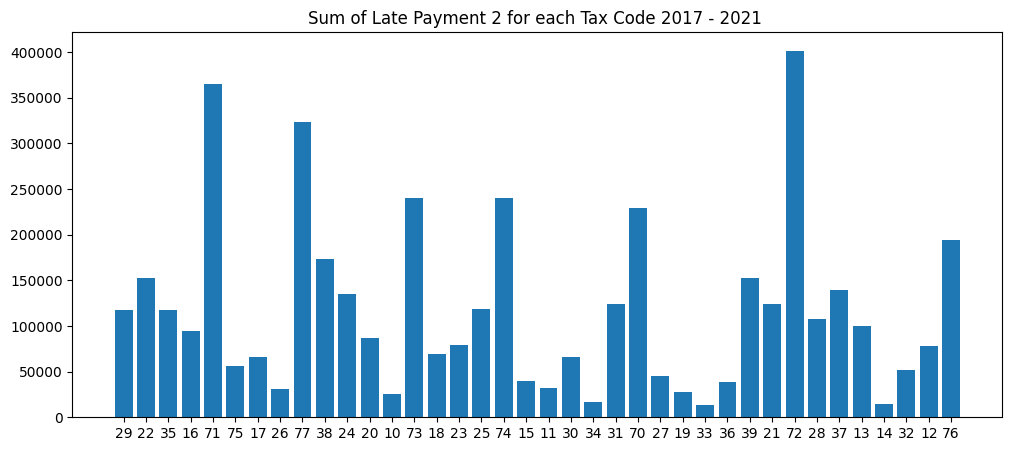

In [ ]:
TC_Counts = allData.groupBy("TC").agg(count("LatePmt2"))
counts = TC_Counts.rdd.map(lambda x: x[1]).collect()
mylabels = TC_Counts.rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.title("Sum of Late Payment 2 for each Tax Code 2017 - 2021 ")
plt.show()


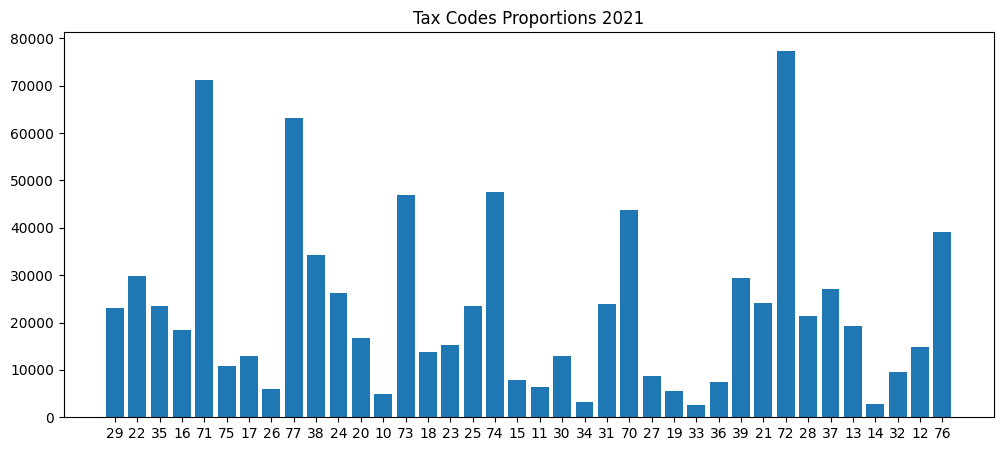

In [ ]:
TC_Counts = data_2021.groupBy("TC").agg(count("TC"))

counts = TC_Counts.rdd.map(lambda x: x[1]).collect()
mylabels = TC_Counts.rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.title("Tax Codes Proportions 2021")
plt.show()

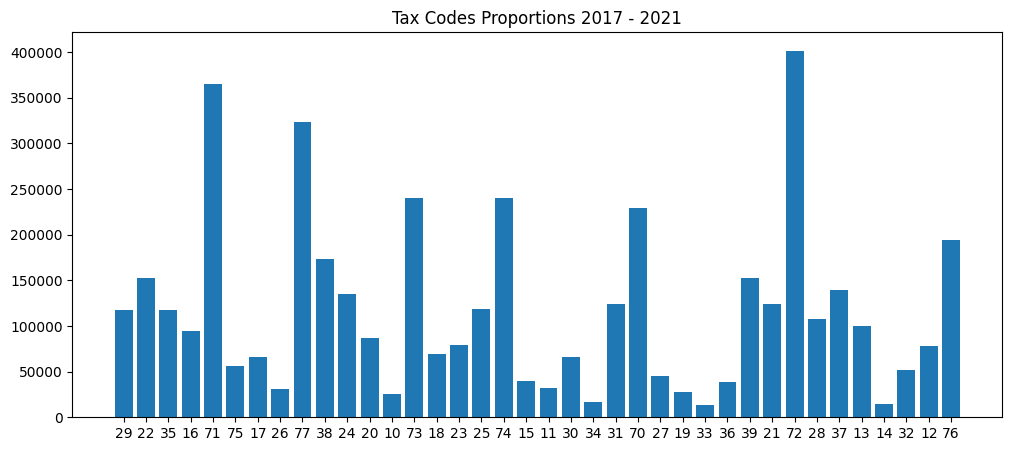

In [ ]:
plt.figure(figsize=(12,5))
plt.bar( mylabels, counts)
plt.title("Tax Codes Proportions 2017 - 2021")
plt.show()

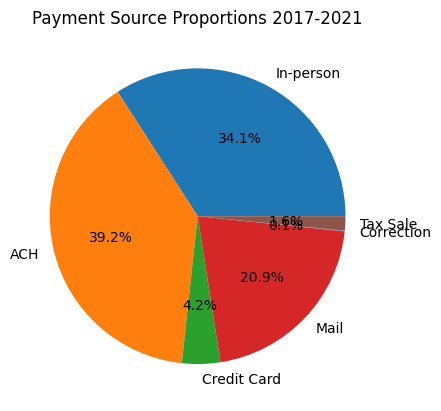

In [ ]:
PmtSrc_Counts_all = allData.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_all.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_all.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("Payment Source Proportions 2017-2021")
plt.show()

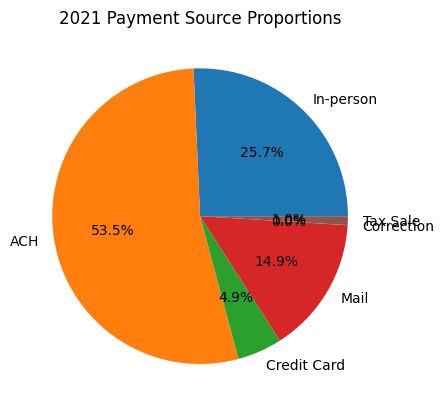

In [ ]:
PmtSrc_Counts_22 = data_2022.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_22.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_22.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2021 Payment Source Proportions")
plt.show()

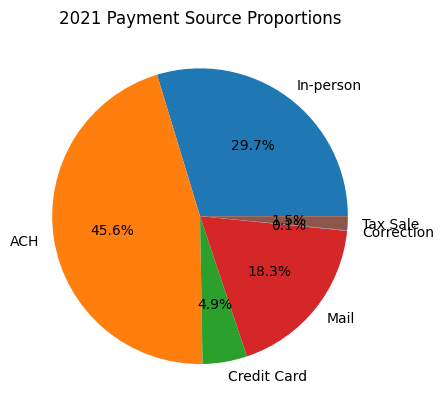

In [ ]:
PmtSrc_Counts_21 = data_2021.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_21.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_21.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2021 Payment Source Proportions")
plt.show()

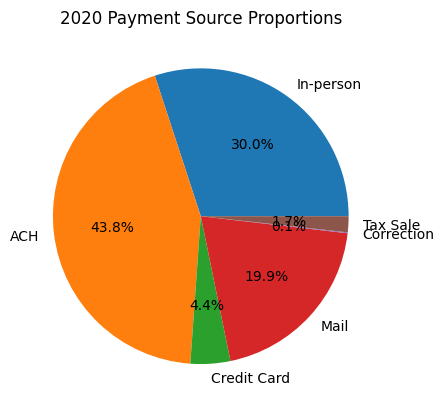

In [ ]:
PmtSrc_Counts_20 = data_2020.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_20.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_20.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2020 Payment Source Proportions")
plt.show()

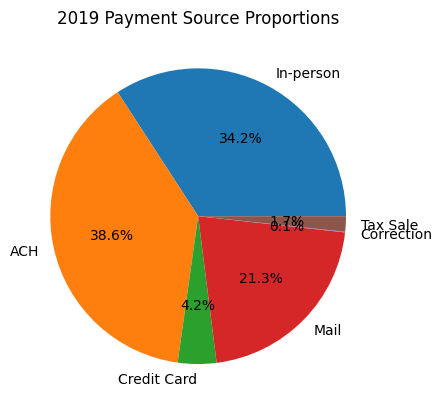

In [ ]:
PmtSrc_Counts_19 = data_2019.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_19.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_19.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2019 Payment Source Proportions")
plt.show()

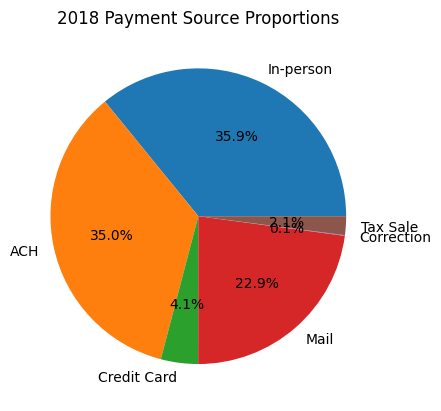

In [ ]:
PmtSrc_Counts_18 = data_2018.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_18.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_18.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2018 Payment Source Proportions")
plt.show()

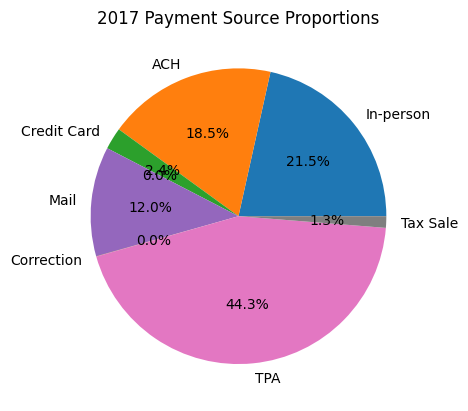

In [ ]:
PmtSrc_Counts_17 = data_2017.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_17.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_17.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels, autopct='%1.1f%%')
plt.title("2017 Payment Source Proportions")
plt.show()


In [ ]:
PmtSrc_Counts_17 = data_2017.groupBy("PmtSrc").agg(count("PmtSrc"))

counts = PmtSrc_Counts_17.rdd.map(lambda x: x[1]).collect()
mylabels = PmtSrc_Counts_17.rdd.map(lambda x: x[0]).collect()

plt.pie(counts, labels = mylabels)
plt.title("2017 Payment Source Proportions")
plt.show()


NameError: ignored

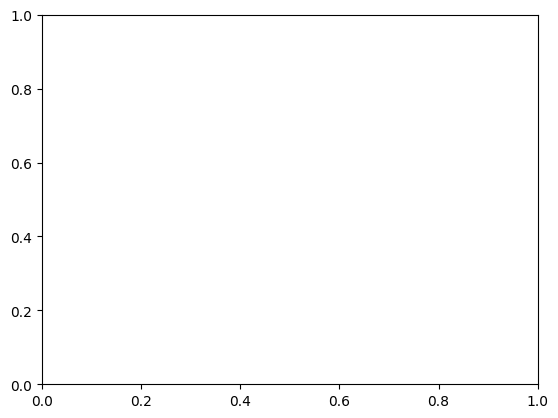

In [ ]:
fig, ax = plt.subplots()
hist(ax, allData.select('DiffPmt1'))
plt.title("Histogram of DiffPmt1 2017 - 2021")
plt.show()

In [ ]:
data_2022.show(10)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
# 2022 data - creating new columns
data_2022 = data_2022.join(instDates, data_2022.TaxYear == instDates.Year, "left")
data_2022 = data_2022.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2022 = data_2022.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2022 = data_2022.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2022 = data_2022.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2022 = data_2022.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2022 = data_2022.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2021 data - creating new columns
data_2021 = data_2021.join(instDates, data_2021.TaxYear == instDates.Year, "left")
data_2021 = data_2021.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2021 = data_2021.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2021 = data_2021.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2021 = data_2021.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2021 = data_2021.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2021 = data_2021.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2020 data - creating new columns
data_2020 = data_2020.join(instDates, data_2020.TaxYear == instDates.Year, "left")
data_2020 = data_2020.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2020 = data_2020.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2020 = data_2020.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2020 = data_2020.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2020 = data_2020.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2020 = data_2020.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2019 data - creating new columns
data_2019 = data_2019.join(instDates, data_2019.TaxYear == instDates.Year, "left")
data_2019 = data_2019.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2019 = data_2019.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2019 = data_2019.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2019 = data_2019.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2019 = data_2019.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2019 = data_2019.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2018 data - creating new columns
data_2018 = data_2018.join(instDates, data_2018.TaxYear == instDates.Year, "left")
data_2018 = data_2018.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2018 = data_2018.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2018 = data_2018.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2018 = data_2018.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2018 = data_2018.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2018 = data_2018.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

# 2017 data - creating new columns
data_2017 = data_2017.join(instDates, data_2017.TaxYear == instDates.Year, "left")
data_2017 = data_2017.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data_2017 = data_2017.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data_2017 = data_2017.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data_2017 = data_2017.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data_2017 = data_2017.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data_2017 = data_2017.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))

In [ ]:
#data transformation 2022 data
data_2022 = data_2022.withColumn("TaxpayerPropertyCity", when(data_2022.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
data_2022 = data_2022.withColumn("TaxpayerMailingState", when(data_2022.TaxpayerMailingState=="IL", 1).otherwise(0))
data_2022 = data_2022.withColumn("BillType", when(data_2022.BillType=="1", 1).otherwise(0))
data_2022 = data_2022.withColumn("TaxSale", when(data_2022.LastPaymentDate2=="00000000", 1).otherwise(0))
data_2022 = data_2022.withColumn("CofENumber", when(data_2022.CofENumber=="0000000", 0).otherwise(1))
data_2022 = data_2022.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data_2022 = data_2022.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
data_2022 = data_2022.withColumn("Volume", col("Volume").cast("int"))
data_2022 = data_2022.withColumn("TaxStatus", col("TaxStatus").cast("int"))
data_2022 = data_2022.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

# Data transformation for all other years
data_list = [data_2021, data_2020, data_2019, data_2018, data_2017]
for data in data_list:
  data = data.withColumn("TaxpayerPropertyCity", when(data.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
  data = data.withColumn("TaxpayerMailingState", when(data.TaxpayerMailingState=="IL", 1).otherwise(0))
  data = data.withColumn("BillType", when(data.BillType=="1", 1).otherwise(0))
  data = data.withColumn("TaxSale", when(data.LastPaymentDate2=="00000000", 1).otherwise(0))
  data = data.withColumn("CofENumber", when(data.CofENumber=="0000000", 0).otherwise(1))
  data = data.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
  data = data.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
  data = data.withColumn("Volume", col("Volume").cast("int"))
  data = data.withColumn("TaxStatus", col("TaxStatus").cast("int"))
  data = data.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

data_2021 = data_list[0]
data_2020 = data_list[1]
data_2019 = data_list[2]
data_2018 = data_list[3]
data_2017 = data_list[4]

In [ ]:
print(data_2021.count())
print(data_2020.count())
print(data_2019.count())
print(data_2018.count())
print(data_2017.count())

1863592
1864779
1865486
1865353
1865486


In [ ]:
# Data transformation for all other years
data_list = [data_2021, data_2020, data_2019, data_2018, data_2017]
for data in data_list:
  data = data.withColumn("TaxpayerPropertyCity", when(data.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
  data = data.withColumn("TaxpayerMailingState", when(data.TaxpayerMailingState=="IL", 1).otherwise(0))
  data = data.withColumn("BillType", when(data.BillType=="1", 1).otherwise(0))
  data = data.withColumn("TaxSale", when(data.LastPaymentDate2=="00000000", 1).otherwise(0))
  data = data.withColumn("CofENumber", when(data.CofENumber=="0000000", 0).otherwise(1))
  data = data.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
  data = data.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
  data = data.withColumn("Volume", col("Volume").cast("int"))
  data = data.withColumn("TaxStatus", col("TaxStatus").cast("int"))
  data = data.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

data_2021 = data_list[0]
data_2020 = data_list[1]
data_2019 = data_list[2]
data_2018 = data_list[3]
data_2017 = data_list[4]


In [ ]:
print(data_2021.count())
print(data_2020.count())
print(data_2019.count())
print(data_2018.count())
print(data_2017.count())

1863592
1864779
1865486
1865353
1865486


In [ ]:
data_2021.columns

['SegmentCode',
 'PIN',
 'Volume',
 'Classification',
 'TaxpayerName',
 'TaxpayerMailingAddress',
 'TaxpayerMailingCity',
 'TaxpayerMailingState',
 'TaxpayerMailingZip',
 'TaxpayerPropertyHouse',
 'TaxpayerPropertyDirection',
 'TaxpayerPropertyStreet',
 'TaxpayerPropertySuffix',
 'TaxpayerPropertyCity',
 'TaxpayerPropertyState',
 'TaxpayerPropertyZip',
 'TaxpayerPropertyTown',
 'TaxCode',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'LongtimeHomeownersExempt',
 'TaxInfoType',
 'TaxType',
 'TaxYear',
 'BillYear',
 'AccountStatus',
 'BillType',
 'SegmentCode2',
 'InstallmentNumber1',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'RefundTaxAmountDueIndicator1',
 'InterestAmountDue1',
 'RefundInterestDueIndicator1',
 'CostAmountDue1',
 'RefundCostDueIndicator1',
 'TotalAmountDue1',
 'RefundTotalDueIndicator1',
 'LastPaymentDate1',
 'LastPaymentSource1',
 'InstallmentNumber2',
 'OriginalTaxDue2',
 'AdjustedTaxDue2',
 'TaxAmountDue2',
 'RefundTaxAmountDueIndicator2'

In [ ]:
print([i for i in range(0, 500, 50)])

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450]


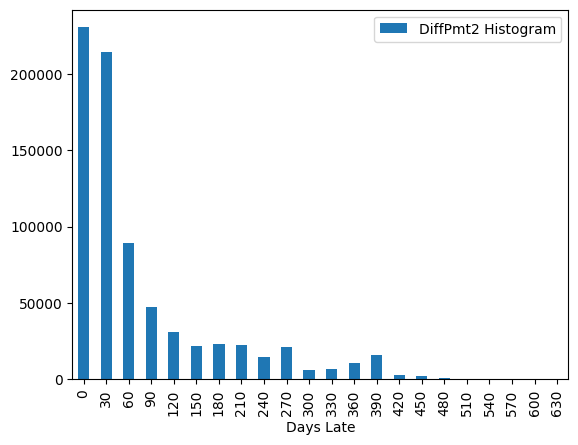

In [ ]:
data = allData
#data = data.withColumn("DiffPmt2", f.datediff(col("LastPaymentDate2"), col("PmtDue2")))
#data = data.withColumn("DiffPmt2", when(col("DiffPmt2")<0,0).otherwise(col("DiffPmt2")))
no_zero = data.where(data.DiffPmt2 > 0)
diff_histogram = no_zero.select('DiffPmt2').rdd.flatMap(lambda x: x).histogram([i for i in range(0, 680, 30)])

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*diff_histogram)),
    columns=['Days Late', 'DiffPmt2 Histogram']
).set_index(
    'Days Late'
).plot(kind='bar');

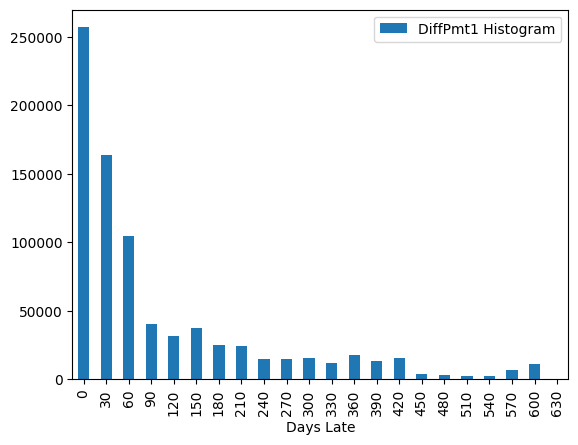

In [ ]:
data = allData
data = data.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data = data.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
no_zero = data.where(data.DiffPmt1 > 0)
diff_histogram = no_zero.select('DiffPmt1').rdd.flatMap(lambda x: x).histogram([i for i in range(0, 680, 30)])

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*diff_histogram)),
    columns=['Days Late', 'DiffPmt1 Histogram']
).set_index(
    'Days Late'
).plot(kind='bar');

In [ ]:
allData.dtypes

[('SegmentCode', 'string'),
 ('PIN', 'string'),
 ('Volume', 'int'),
 ('Classification', 'string'),
 ('TaxpayerName', 'string'),
 ('TaxpayerMailingAddress', 'string'),
 ('TaxpayerMailingCity', 'string'),
 ('TaxpayerMailingState', 'int'),
 ('TaxpayerMailingZip', 'string'),
 ('TaxpayerPropertyHouse', 'string'),
 ('TaxpayerPropertyDirection', 'string'),
 ('TaxpayerPropertyStreet', 'string'),
 ('TaxpayerPropertySuffix', 'string'),
 ('TaxpayerPropertyCity', 'int'),
 ('TaxpayerPropertyState', 'string'),
 ('TaxpayerPropertyZip', 'string'),
 ('TaxpayerPropertyTown', 'string'),
 ('TaxCode', 'string'),
 ('TaxStatus', 'int'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('LongtimeHomeownersExempt', 'string'),
 ('TaxInfoType', 'string'),
 ('TaxType', 'string'),
 ('TaxYear', 'string'),
 ('BillYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'int'),
 ('SegmentCode2', 'string'),
 ('InstallmentNumber1', 'string'),
 ('AdjustedAmountDue1', 

In [ ]:

allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")<=30, 1))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1") == 0, 0))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>30, 2))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>60, 3))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>90, 4))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>120, 5))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>150, 6))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>180, 7))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>210, 8))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>240, 9))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>270, 10))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>300, 11))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>330, 12))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>360, 13))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>390, 14))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>420, 15))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>450, 16))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>480, 17))
allData = allData.withColumn("LateInterval1", when(col("DiffPmt1")>500, 18))



In [ ]:
from pyspark.sql.functions import when

In [ ]:
allData = allData.withColumn("LateInterval1", \
   when((allData.DiffPmt1 <= 30 ), 1) \
                             .when((allData.DiffPmt1 == 00), 0) \
                             .when((allData.DiffPmt1 > 30), 2) \
                             .when((allData.DiffPmt1 > 60) , 3) \
                             .when((allData.DiffPmt1 > 90), 4) \
                             .when((allData.DiffPmt1 > 120), 5) \
                             .when((allData.DiffPmt1 > 150), 6) \
                             .when((allData.DiffPmt1 > 180), 7) \
                             .when((allData.DiffPmt1 > 210), 8) \
                             .when((allData.DiffPmt1 > 240), 9) \
                             .when((allData.DiffPmt1 > 270), 10) \
                             .when((allData.DiffPmt1 > 300), 11) \
                             .when((allData.DiffPmt1 > 330), 12) \
                             .when((allData.DiffPmt1 > 360), 13) \
                             .when((allData.DiffPmt1 > 390), 14) \
                             .when((allData.DiffPmt1 > 420), 15) \
                             .when((allData.DiffPmt1 > 450), 16) \
                             .when((allData.DiffPmt1 > 480), 17) \
                             .when((allData.DiffPmt1 > 500), 18) \
                             .otherwise(-1))

In [ ]:
allData.groupBy("LateInterval1").agg(count("PIN")).show(20)

+-------------+----------+
|LateInterval1|count(PIN)|
+-------------+----------+
|            1|   3622218|
|            2|    546717|
+-------------+----------+



In [ ]:
data_list = [data_2022, data_2021, data_2020, data_2019, data_2018, data_2017]

In [ ]:
data_2022.dtypes

[('SegmentCode', 'string'),
 ('PIN', 'string'),
 ('Volume', 'int'),
 ('Classification', 'string'),
 ('TaxpayerName', 'string'),
 ('TaxpayerMailingAddress', 'string'),
 ('TaxpayerMailingCity', 'string'),
 ('TaxpayerMailingState', 'int'),
 ('TaxpayerMailingZip', 'string'),
 ('TaxpayerPropertyHouse', 'string'),
 ('TaxpayerPropertyDirection', 'string'),
 ('TaxpayerPropertyStreet', 'string'),
 ('TaxpayerPropertySuffix', 'string'),
 ('TaxpayerPropertyCity', 'int'),
 ('TaxpayerPropertyState', 'string'),
 ('TaxpayerPropertyZip', 'string'),
 ('TaxpayerPropertyTown', 'string'),
 ('TaxCode', 'string'),
 ('TaxStatus', 'int'),
 ('HomeownerExempt', 'string'),
 ('SeniorExempt', 'string'),
 ('SeniorFreezeExempt', 'string'),
 ('LongtimeHomeownersExempt', 'string'),
 ('TaxInfoType', 'string'),
 ('TaxType', 'string'),
 ('TaxYear', 'string'),
 ('BillYear', 'string'),
 ('AccountStatus', 'string'),
 ('BillType', 'int'),
 ('SegmentCode2', 'string'),
 ('InstallmentNumber1', 'string'),
 ('AdjustedAmountDue1', 

In [ ]:
data_2021.select("TC").distinct().collect()

[Row(TC='29'),
 Row(TC='22'),
 Row(TC='35'),
 Row(TC='16'),
 Row(TC='71'),
 Row(TC='75'),
 Row(TC='17'),
 Row(TC='26'),
 Row(TC='77'),
 Row(TC='38'),
 Row(TC='24'),
 Row(TC='20'),
 Row(TC='10'),
 Row(TC='73'),
 Row(TC='18'),
 Row(TC='23'),
 Row(TC='25'),
 Row(TC='74'),
 Row(TC='15'),
 Row(TC='11'),
 Row(TC='30'),
 Row(TC='34'),
 Row(TC='31'),
 Row(TC='70'),
 Row(TC='27'),
 Row(TC='19'),
 Row(TC='33'),
 Row(TC='36'),
 Row(TC='39'),
 Row(TC='21'),
 Row(TC='72'),
 Row(TC='28'),
 Row(TC='37'),
 Row(TC='13'),
 Row(TC='14'),
 Row(TC='32'),
 Row(TC='12'),
 Row(TC='76')]

In [ ]:
data_2021.show(20)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
# ******* Do not use this cell ***************
# Use this to find a list of unique tax codes for each year
TC_list_2021 = list(data_2021.select("TC").distinct().collect())
TC_list_2021 = [list(i) for i in TC_list_2021]
print(TC_list_2021)
print(len(TC_list_2021))
TC_list_2021 = [TC_list_2021[i][0] for i in range(len(TC_list_2021))]
print(TC_list_2021)

In [ ]:
# TC_list contains list of unique Tax Codes for each year in descending order starting from 2022
TC_list = []
for i in range(len(data_list)):
  year = str(2022 - i)
  data = data_list[i]
  unique_TC = list(data.select("TC").distinct().collect())
  unique_TC = [list(j) for j in unique_TC]
  unique_TC = [unique_TC[j][0] for j in range(len(unique_TC))]
  TC_list.append(unique_TC)

print(len(TC_list))
print(TC_list[0])
print(TC_list[1])





6
['11', '73', '34', '71', '31', '75', '17', '26', '77', '25', '33', '20', '74']
['29', '22', '35', '16', '71', '75', '17', '26', '77', '38', '24', '20', '10', '73', '18', '23', '25', '74', '15', '11', '30', '34', '31', '70', '27', '19', '33', '36', '39', '21', '72', '28', '37', '13', '14', '32', '12', '76']


In [ ]:
for i in range(6):
  print(i, len(TC_list[i]))

0 13
1 38
2 38
3 38
4 38
5 38


In [ ]:
# 2021 data used ****** Use the next code **********
TC_data_list_2021 = [] # contains a list of filtered dataframes for each tax code
unique_TC_2021 = TC_list[1] # list of unique tax codes for 2021
total_TC_counts_2021 = [] # list of count of total rows for each tax code in 2021
for tc in unique_TC_2021:
  data = data_2021.filter(data_2021.TC == tc)
  total_TC_counts_2021.append(data.count())
  TC_data_list_2021.append(data)

print(len(TC_data_list_2021))
print(len(total_TC_counts_2021))
print(total_TC_counts_2021)
print(TC_data_list_2021[0].count())

38
38
[43824, 53100, 47436, 32949, 156305, 23387, 24888, 9872, 150952, 60322, 46307, 34128, 8045, 101131, 34279, 23164, 36348, 79047, 17202, 15545, 23072, 6461, 56532, 108471, 18976, 9956, 4518, 15154, 64847, 44599, 190841, 40908, 78382, 52444, 7147, 29797, 40925, 72331]
43824


In [ ]:
# 2021 data used
TC_data_list_2021 = [] # contains a list of filtered dataframes for each tax code
unique_TC_2021 = TC_list[1] # list of unique tax codes for 2021
total_TC_counts_2021 = [] # list of count of total rows for each tax code in 2021
percent_late_1_2021 = [] # for each tax code, what percent of the paid the first payment late
percent_late_2_2021 = [] # for each tax code, what percent of the paid the second payment late

for tc in unique_TC_2021:
  data = data_2021.filter(data_2021.TC == tc)
  total = data.count()
  percent_late_1_2021.append(data.filter(data.LatePmt1 == 1).count() / total * 100)
  percent_late_2_2021.append(data.filter(data.LatePmt2 == 1).count() / total * 100)
  total_TC_counts_2021.append(total)
  TC_data_list_2021.append(data)

In [ ]:
# 2020 data used
TC_data_list_2020 = [] # contains a list of filtered dataframes for each tax code
unique_TC_2020 = TC_list[2] # list of unique tax codes for 2020
total_TC_counts_2020 = [] # list of count of total rows for each tax code in 2020
percent_late_1_2020 = [] # for each tax code, what percent of the paid the first payment late
percent_late_2_2020 = [] # for each tax code, what percent of the paid the second payment late

for tc in unique_TC_2020:
  data = data_2020.filter(data_2020.TC == tc)
  total = data.count()
  percent_late_1_2020.append(data.filter(data.LatePmt1 == 1).count() / total * 100)
  percent_late_2_2020.append(data.filter(data.LatePmt2 == 1).count() / total * 100)
  total_TC_counts_2020.append(total)
  TC_data_list_2020.append(data)

print(len(total_TC_counts_2020))
print(len(percent_late_1_2020))
print(len(percent_late_2_2020))

print(total_TC_counts_2020)
print(percent_late_1_2020)
print(percent_late_2_2020)
print(unique_TC_2020)

38
38
38
[43443, 53164, 47444, 32952, 156350, 34419, 23579, 24946, 9864, 23180, 60386, 36319, 46487, 34048, 8058, 101361, 150011, 6457, 56533, 19059, 4529, 78851, 17199, 15582, 108489, 15149, 44623, 73804, 190849, 23039, 9912, 40870, 64853, 7145, 29811, 78525, 40924, 52565]
[16.01178555808761, 18.266119930780228, 14.870162718151928, 18.229546006312212, 15.878477774224498, 12.49309974142189, 17.2271936892998, 15.589673695181592, 18.795620437956202, 18.934426229508198, 16.7472592985129, 18.601833750929266, 17.391959042312905, 17.995183270676694, 19.012161826756017, 16.41262418484427, 19.981867996346935, 14.66625367817872, 16.100330780252243, 15.000787029749723, 19.938176197836167, 20.13037247466741, 20.727949299377872, 16.204595045565394, 22.556203854768686, 16.278302198164894, 16.993478699325458, 18.925803479486206, 20.624682340489077, 18.017275055340946, 15.032284100080709, 13.760704673354537, 16.013137403049974, 19.94401679496151, 17.137969205997784, 19.33142311365807, 18.104290880656

In [ ]:
# 2019 data used
TC_data_list_2019 = [] # contains a list of filtered dataframes for each tax code
unique_TC_2019 = TC_list[3] # list of unique tax codes for 2020
total_TC_counts_2019 = [] # list of count of total rows for each tax code in 2020
percent_late_1_2019 = [] # for each tax code, what percent of the paid the first payment late
percent_late_2_2019 = [] # for each tax code, what percent of the paid the second payment late

for tc in unique_TC_2019:
  data = data_2019.filter(data_2019.TC == tc)
  total = data.count()
  percent_late_1_2019.append(data.filter(data.LatePmt1 == 1).count() / total * 100)
  percent_late_2_2019.append(data.filter(data.LatePmt2 == 1).count() / total * 100)
  total_TC_counts_2019.append(total)
  TC_data_list_2019.append(data)

print(len(total_TC_counts_2019))
print(len(percent_late_1_2019))
print(len(percent_late_2_2019))

print(total_TC_counts_2019)
print(percent_late_1_2019)
print(percent_late_2_2019)
print(unique_TC_2019)

38
38
38
[43419, 53063, 47345, 33178, 156251, 34406, 24947, 23202, 60407, 36431, 7990, 23845, 9864, 46509, 34085, 102014, 56625, 108707, 149642, 4525, 15153, 79117, 191050, 73088, 17201, 15575, 6461, 19072, 44534, 23037, 9959, 40870, 78677, 64870, 52492, 7148, 29790, 40937]
[5.131394090144868, 5.2315172530765315, 4.676312176576196, 5.220326722526976, 6.174680482044915, 4.769516944718944, 6.429630817332746, 6.663218688044134, 5.285811247040906, 5.599626691553897, 6.88360450563204, 7.3893898091843155, 4.785077047850771, 5.783826786213421, 6.551268886607012, 6.470680494834043, 7.924061810154526, 15.97321239662579, 10.570561740687774, 6.386740331491712, 6.473965551375965, 7.272773234576639, 13.233708453284482, 6.631731611208407, 10.208708796000233, 7.017656500802569, 5.277820770778517, 5.945889261744966, 6.451250729779494, 5.912228154707645, 5.24149010944874, 4.480058722779545, 12.921184081751974, 6.619392631416679, 8.43747618684752, 13.696138780078343, 10.412890231621349, 11.5616679287685

In [ ]:
print(len(total_TC_counts_2021))
print(len(percent_late_1_2021))
print(len(percent_late_2_2021))

print(total_TC_counts_2021)
print(percent_late_1_2021)
print(percent_late_2_2021)

38
38
38
[43824, 53100, 47436, 32949, 156305, 23387, 24888, 9872, 150952, 60322, 46307, 34128, 8045, 101131, 34279, 23164, 36348, 79047, 17202, 15545, 23072, 6461, 56532, 108471, 18976, 9956, 4518, 15154, 64847, 44599, 190841, 40908, 78382, 52444, 7147, 29797, 40925, 72331]
[6.621942314713398, 6.962335216572504, 6.336959271439413, 6.6527056966827525, 7.702248808419436, 9.359900799589516, 8.116361298617807, 6.614667747163695, 11.689146218665536, 6.868140976758065, 7.389811475586844, 7.946554149085795, 8.65133623368552, 8.777723942213566, 6.280813325942996, 9.33776549818684, 7.975679542203147, 11.178159828962515, 10.690617370073248, 8.247024766806046, 7.9446948682385585, 5.680235257700046, 8.522606665251539, 15.602326889214629, 7.583263069139965, 6.759742868621936, 8.211598052235502, 7.331397650785271, 7.724335744136197, 8.228884055696316, 13.23824545040112, 5.923046836804537, 13.267076624735271, 9.221264586988024, 11.837134462012033, 9.47410813169111, 11.469761759315823, 9.3956947919978

In [ ]:
print(unique_TC_2021)

['29', '22', '35', '16', '71', '75', '17', '26', '77', '38', '24', '20', '10', '73', '18', '23', '25', '74', '15', '11', '30', '34', '31', '70', '27', '19', '33', '36', '39', '21', '72', '28', '37', '13', '14', '32', '12', '76']


In [ ]:
data_2022.show(10)

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
# 2022 data find percentages of late payments wrt tax codes
LatePmt1_list = []
LatePmt2_list = []
TC_count = []
for i in range(len(data_list)):
  year = str(2022 - i)
  data = data_list[i]
  unique_TC = TC_list[i]
  percent_late_list_1 = []
  percent_late_list_2 = []
  count_TC = []
  total_year_dataset = data.count()
  for TC in unique_TC:
    filtered_data = data.filter(data.TC == TC)
    total = filtered_data.count()
    percent_late1 = filtered_data.filter(filtered_data.LatePmt1 == 1).count() / total * 100
    percent_late2 = filtered_data.filter(filtered_data.LatePmt2 == 1).count() / total * 100
    percent_late_list_1.append(percent_late1)
    percent_late_list_2.append(percent_late2)
    count_TC.append(total)
  LatePmt1_list.append(percent_late_list_1)
  LatePmt2_list.append(percent_late_list_2)
  TC_count.append(count_TC)



In [ ]:
print((LatePmt1_list))

[[6.621942314713398, 6.962335216572504, 6.336959271439413, 6.6527056966827525, 7.702248808419436, 9.359900799589516, 8.116361298617807, 6.614667747163695, 11.689146218665536, 6.868140976758065, 7.389811475586844, 7.946554149085795, 8.65133623368552, 8.777723942213566, 6.280813325942996, 9.33776549818684, 7.975679542203147, 11.178159828962515, 10.690617370073248, 8.247024766806046, 7.9446948682385585, 5.680235257700046, 8.522606665251539, 15.602326889214629, 7.583263069139965, 6.759742868621936, 8.211598052235502, 7.331397650785271, 7.724335744136197, 8.228884055696316, 13.23824545040112, 5.923046836804537, 13.267076624735271, 9.221264586988024, 11.837134462012033, 9.47410813169111, 11.469761759315823, 9.395694791997897]]


In [ ]:
year = str(2022 - i)
data = data_list[i]
unique_TC = TC_list[i]
percent_late_list_1 = []
percent_late_list_2 = []
for TC in unique_TC:
  filtered_data = data.filter(data.TC == TC)
  total = filtered_data.count()
  percent_late1 = filtered_data.filter(filtered_data.LatePmt1 == 1).count() / total * 100
  percent_late2 = filtered_data.filter(filtered_data.LatePmt2 == 1).count() / total * 100
  percent_late_list_1.append(percent_late1)
  percent_late_list_2.append(percent_late2)
LatePmt1_list.insert(0, percent_late_list_1)
LatPmt2_list.insert(0, percent_late_list_2)

In [ ]:
print(unique_TC)

['29', '22', '35', '16', '71', '18', '17', '23', '38', '25', '10', '75', '26', '24', '20', '73', '31', '70', '77', '33', '36', '74', '72', '76', '15', '11', '34', '27', '21', '30', '19', '28', '37', '39', '13', '14', '32', '12']


In [ ]:
# 2022 data used
TC_11 = data_2022.filter(data_2022.TC == "11")
TC_73 = data_2022.filter(data_2022.TC == "73")
TC_34 = data_2022.filter(data_2022.TC == "34")
TC_71 = data_2022.filter(data_2022.TC == "71")
TC_31 = data_2022.filter(data_2022.TC == "31")
TC_75 = data_2022.filter(data_2022.TC == "75")
TC_17 = data_2022.filter(data_2022.TC == "17")
TC_26 = data_2022.filter(data_2022.TC == "26")
TC_77 = data_2022.filter(data_2022.TC == "77")
TC_25 = data_2022.filter(data_2022.TC == "25")
TC_33 = data_2022.filter(data_2022.TC == "33")
TC_20 = data_2022.filter(data_2022.TC == "20")
TC_74 = data_2022.filter(data_2022.TC == "74")

In [ ]:
TC_List = [TC_11, TC_73, TC_34, TC_71, TC_31, TC_75, TC_17, TC_26, TC_77, TC_25, TC_33, TC_20, TC_74]

for i in TC_List:
  data = i
  total = data.count()
  percent_late = data.filter(data.LatePmt1 == 1).count() / total * 100
  percent_not_late = data.filter(data.LatePmt1 == 0).count() / total * 100
  print(total, percent_late, percent_not_late)


# print(TC_11.count())
# print(TC_11_Late.count())
# print(TC_11_NotLate.count())

14 14.285714285714285 85.71428571428571
31525 4.066613798572562 95.93338620142744
25 4.0 96.0
22849 3.6675565670270034 96.332443432973
28293 4.612448308768954 95.38755169123104
5405 5.272895467160037 94.72710453283997
4563 4.1639272408503185 95.83607275914969
800 3.0 97.0
11127 4.700278601599712 95.29972139840028
42 2.380952380952381 97.61904761904762
2688 4.427083333333334 95.57291666666666
1302 3.3794162826420893 96.62058371735792
7674 4.404482668751629 95.59551733124837


In [ ]:
print([TC_11.count(), len(TC_11.columns)])
print([TC_73.count(), len(TC_73.columns)])
print([TC_34.count(), len(TC_34.columns)])
print([TC_71.count(), len(TC_71.columns)])
print([TC_31.count(), len(TC_31.columns)])
print([TC_75.count(), len(TC_75.columns)])
print([TC_17.count(), len(TC_17.columns)])
print([TC_26.count(), len(TC_26.columns)])
print([TC_77.count(), len(TC_77.columns)])
print([TC_25.count(), len(TC_25.columns)])
print([TC_33.count(), len(TC_33.columns)])
print([TC_20.count(), len(TC_20.columns)])
print([TC_74.count(), len(TC_74.columns)])

[14, 89]
[31525, 89]
[25, 89]
[22849, 89]
[28293, 89]
[5405, 89]
[4563, 89]
[800, 89]
[11127, 89]
[42, 89]
[2688, 89]
[1302, 89]
[7674, 89]


In [ ]:
len(data_2022.columns)

89

In [ ]:
!pip install pyspark_dist_explore
from pyspark_dist_explore import hist

In [ ]:
from pyspark_dist_explore import hist

In [ ]:
TC_11.select("LatePmt1").distinct().collect()
#TC_11_Late1 =

[Row(LatePmt1=1), Row(LatePmt1=0)]

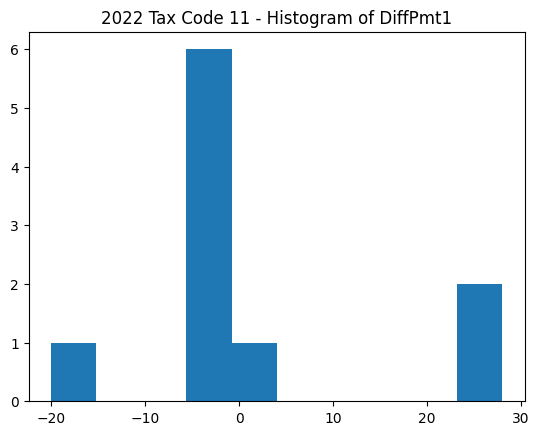

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_11.select('DiffPmt1'))
plt.title("2022 Tax Code 11 - Histogram of DiffPmt1")
plt.show()

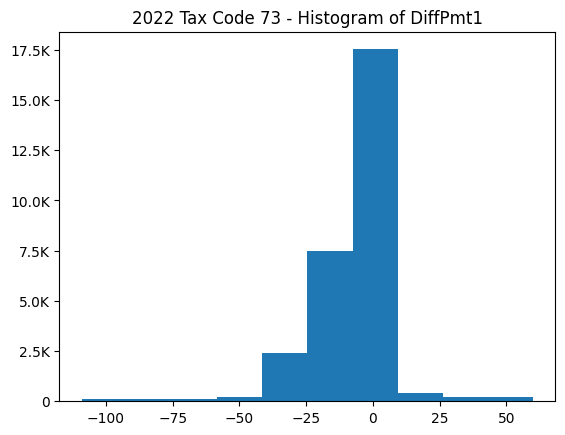

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_73.select('DiffPmt1'))
plt.title("2022 Tax Code 73 - Histogram of DiffPmt1")
plt.show()

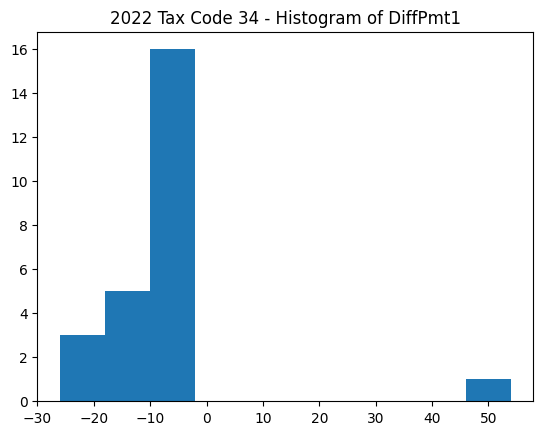

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_34.select('DiffPmt1'))
plt.title("2022 Tax Code 34 - Histogram of DiffPmt1")
plt.show()

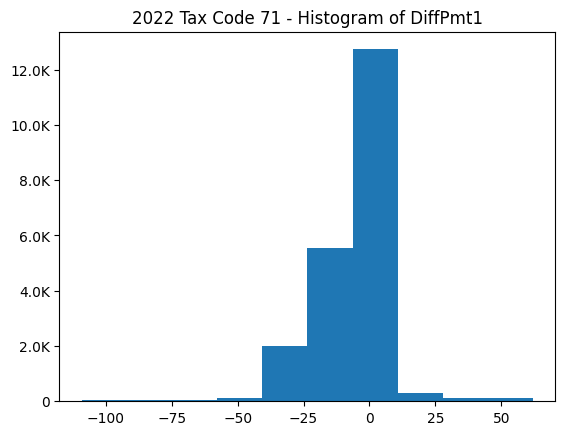

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_71.select('DiffPmt1'))
plt.title("2022 Tax Code 71 - Histogram of DiffPmt1")
plt.show()

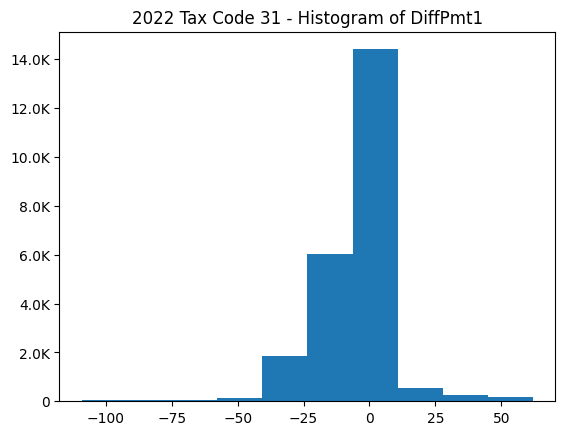

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_31.select('DiffPmt1'))
plt.title("2022 Tax Code 31 - Histogram of DiffPmt1")
plt.show()

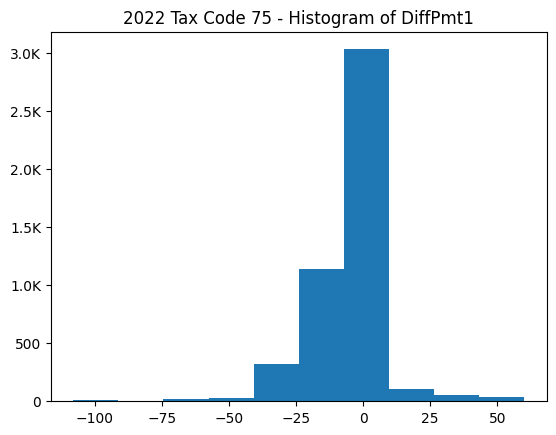

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_75.select('DiffPmt1'))
plt.title("2022 Tax Code 75 - Histogram of DiffPmt1")
plt.show()

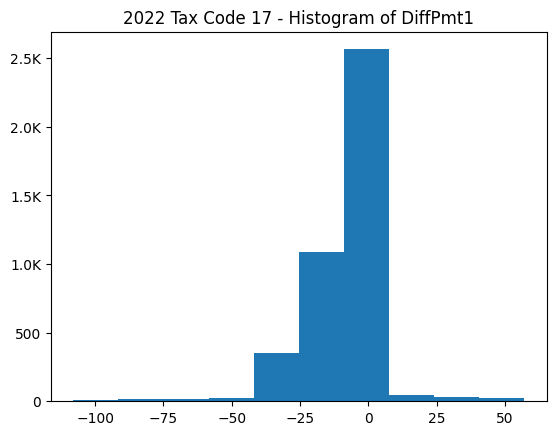

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_17.select('DiffPmt1'))
plt.title("2022 Tax Code 17 - Histogram of DiffPmt1")
plt.show()

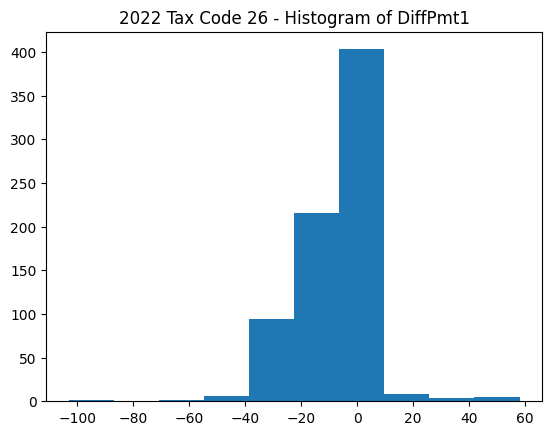

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_26.select('DiffPmt1'))
plt.title("2022 Tax Code 26 - Histogram of DiffPmt1")
plt.show()

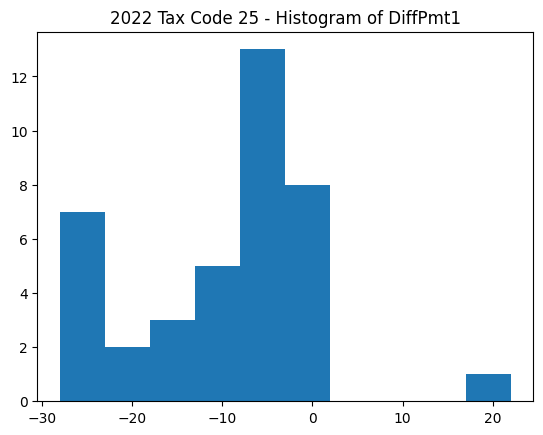

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_25.select('DiffPmt1'))
plt.title("2022 Tax Code 25 - Histogram of DiffPmt1")
plt.show()

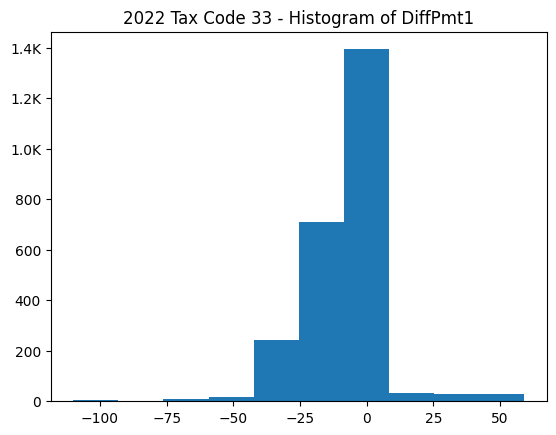

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_33.select('DiffPmt1'))
plt.title("2022 Tax Code 33 - Histogram of DiffPmt1")
plt.show()

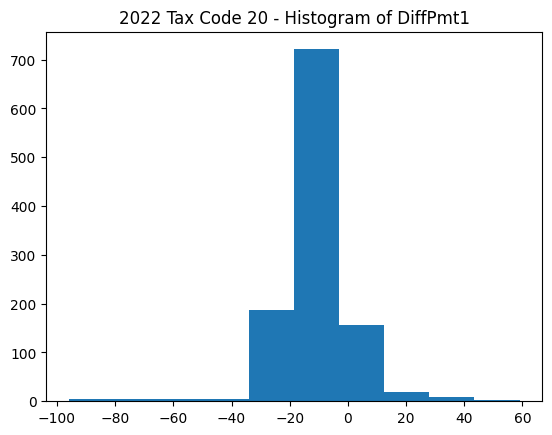

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_20.select('DiffPmt1'))
plt.title("2022 Tax Code 20 - Histogram of DiffPmt1")
plt.show()

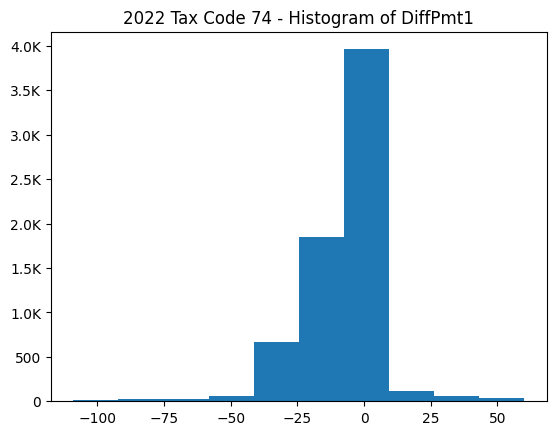

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_74.select('DiffPmt1'))
plt.title("2022 Tax Code 74 - Histogram of DiffPmt1")
plt.show()

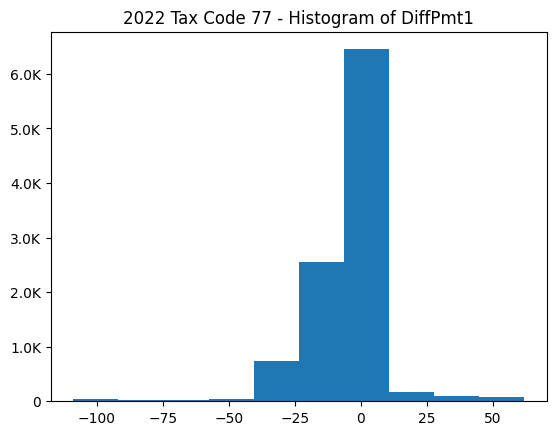

In [ ]:
fig, ax = plt.subplots()
hist(ax, TC_77.select('DiffPmt1'))
plt.title("2022 Tax Code 77 - Histogram of DiffPmt1")
plt.show()

In [ ]:
trans_2022 = data_2022.persist()